# Demo for Top-down Neural Attention

This is an example to show how to use Excitation Backprop to visualize CNN classifier's top-down attention.

In [14]:
from prelude import *
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform, filter
import sys, pylab, operator, csv
import util
import os
import urllib
%matplotlib inline

from visualisation import overlay_attention_map
from excitation_backprop import ExcitationBackprop
import caffe
import transformers
import excitation_backprop as ebp

caffe.__file__

'/home/will/src/Caffe-ExcitationBP/python/caffe/__init__.py'

In [15]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We first load the model files and set the top layers' name.

In [16]:
model_root = os.path.join(config.NETS_ROOT, "coco")
try: 
    model_prototxt_path = os.path.join(model_root, 'deploy.prototxt')
    model_caffemodel_path = os.path.join(model_root, 'GoogleNetCOCO.caffemodel')
except FileNotFoundError:
    url = 'http://www.cs.bu.edu/groups/ivc/data/ExcitationBP/COCO/GoogleNetCOCO.caffemodel'
    urllib.request.urlretrieve(url, model_caffemodel_path)
    
caffe.set_mode_gpu()
net = caffe.Net(model_prototxt_path,
                model_caffemodel_path,
                caffe.TRAIN)
tags,tag2ID = util.loadTags(os.path.join(model_root, 'catName.txt'))
param = dict()
imgScale = 224
topLayerName = 'loss3/classifier'
topBlobName = net.top_names[topLayerName][0]
secondTopLayerName = 'pool5/7x7_s1'
secondTopBlobName = net.top_names[secondTopLayerName][0]

We load an image. 
The image is resized to 224 for the shortest dimension.
Since the provided CNN model is converted to a fully convolutional model, we can input images of arbitrary aspect ratio.

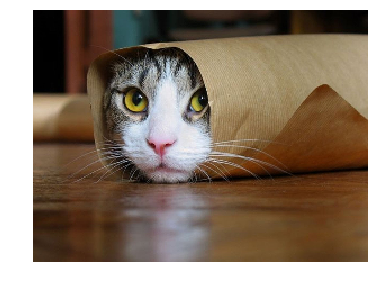

In [17]:
imgName = '../../media/images/cat.jpg'
img = caffe.io.load_image(imgName)
minDim = min(img.shape[:2])
newSize = (int(img.shape[0]*imgScale/float(minDim)), int(img.shape[1]*imgScale/float(minDim)))
imgS = transform.resize(img, newSize)
pylab.rcParams['figure.figsize'] = (6.0, 6.0)
plt.axis('off')
plt.imshow(imgS)

We do a forward pass and show the top predictions.

In [18]:
net.blobs['data'].reshape(1,3,newSize[0],newSize[1])
transformer = transformers.imagenet_transformer(net)

net.blobs['data'].data[...] = transformer.preprocess('data', imgS)
out = net.forward(end = topLayerName)

scores = net.blobs[topBlobName].data[0].reshape((len(tags),-1)).max(1).flatten() # pre-softmax scores
tagScore = util.getTagScore(scores, tags, tag2ID)
tagScore.sort(key = operator.itemgetter(1), reverse = True)
print(tagScore[:10])

[('cat', 0.97680104), ('person', 0.0042877547), ('couch', 0.0025291217), ('bed', 0.0019387519), ('chair', 0.0017517552), ('bird', 0.0011646389), ('book', 0.0011110975), ('dining table', 0.00087078568), ('potted plant', 0.00082940288), ('umbrella', 0.00079300796)]


In [19]:
prediction = tagScore[0][0]

(-0.5, 297.5, 223.5, -0.5)

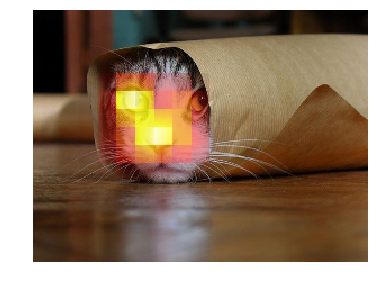

In [23]:
attMap = ExcitationBackprop(net, 'loss3/classifier', 'pool5/7x7_s1', 'pool3/3x3_s2').backprop(tag2ID[prediction])
pylab.rcParams['figure.figsize'] = (6.0, 6.0)
plt.imshow(overlay_attention_map(imgS, attMap))
plt.axis('off')

Now we try to visualize several object categories present in this image using our contrastive attention formulation.  

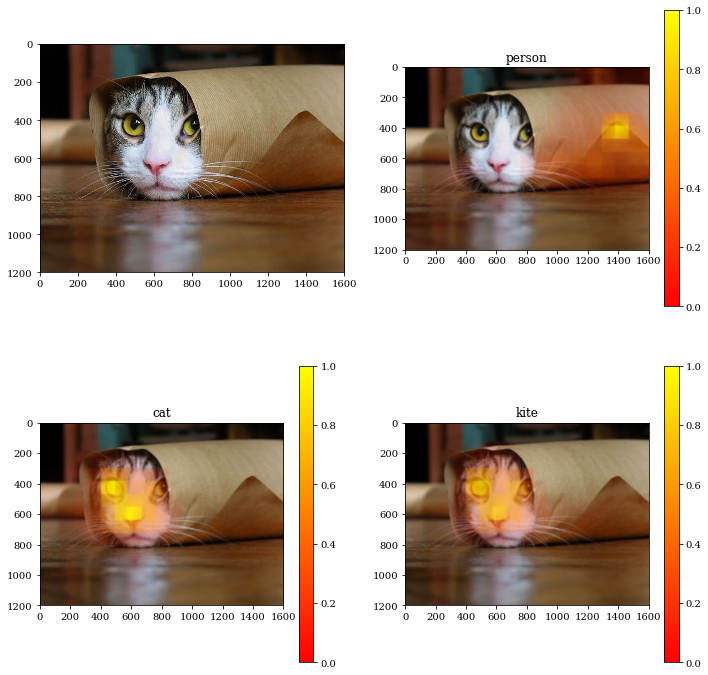

In [24]:
# switch to the excitation backprop mode
caffe.set_mode_eb_gpu() 
# specify the tags
tagName = ['person', 'cat', 'kite']
#specify the output layer name
outputLayerName = 'pool3/3x3_s2'#'inception_5b/output'
outputBlobName = net.top_names[outputLayerName][0] #'inception_5b/output'

excitation_backprop = ebp.ExcitationBackprop(net, 
    topLayerName, secondTopLayerName, outputLayerName,
    top_blob_name=topBlobName, second_top_blob_name=secondTopBlobName,
    output_blob_name=outputBlobName)

attMaps = []

for i in range(len(tagName)):
    tagID = tag2ID[tagName[i]]
    attMap = excitation_backprop.backprop(tagID)
    attMaps.append(attMap)

util.showAttMap(img, attMaps, tagName, overlap = True, blur = False)
